In [2]:
from pandas import Series, DataFrame
import pandas as pd
from patsy import dmatrices
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
spotify=pd.read_csv("Spotify-2000.csv", thousands=",")
spotify.drop('Index',axis=1, inplace=True)


In [4]:
pd.crosstab(spotify['Top Genre'], spotify['Year']).idxmax()

Year
1956    adult standards
1958    adult standards
1959    adult standards
1960    adult standards
1961    adult standards
             ...       
2015        dutch indie
2016       british soul
2017                pop
2018          dutch pop
2019         album rock
Length: 63, dtype: object

## HeatMap

Some key correlations to note: (Loudness, Energy), (Valence, Danceability), (Loudness, Year), (Valence, Energy), (Energy, Acousticness), (Loudness Acousticness)

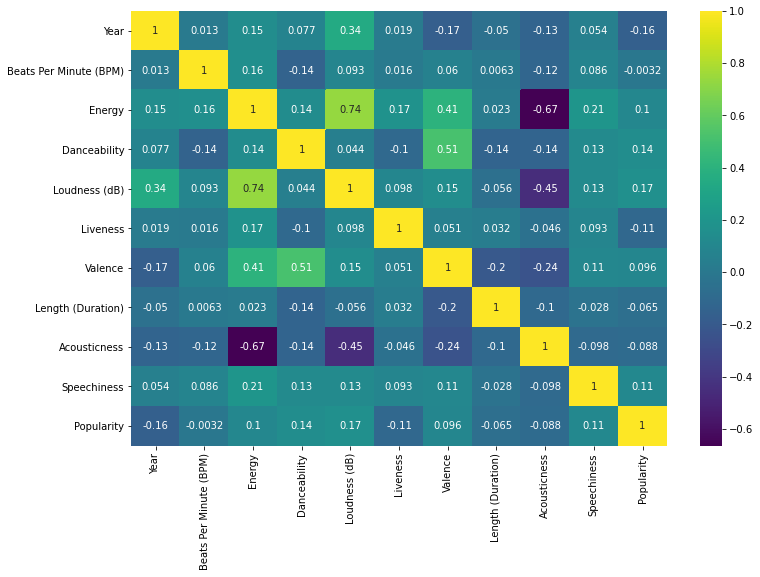

In [5]:
plt.figure(figsize=(12,8))
sns.heatmap(spotify.corr(), cmap="viridis", annot=True )

In [6]:
popularity_rank = spotify['Popularity'].rank(ascending=True)


In [7]:
popularity_percentile = pd.qcut(popularity_rank,
                                4,
                                labels=['low', 'medium', 'high',
                                        "insanely good"])

In [8]:
spotify['Percentile'] = popularity_percentile
spotify

,Title,Artist,Top Genre,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity,Percentile
0,Sunrise,Norah Jones,adult standards,2004,157,30,53,-14,11,68,201,94,3,71,high
1,Black Night,Deep Purple,album rock,2000,135,79,50,-11,17,81,207,17,7,39,low
2,Clint Eastwood,Gorillaz,alternative hip hop,2001,168,69,66,-9,7,52,341,2,17,69,high
3,The Pretender,Foo Fighters,alternative metal,2007,173,96,43,-4,3,37,269,0,4,76,insanely good
4,Waitin' On A Sunny Day,Bruce Springsteen,classic rock,2002,106,82,58,-5,10,87,256,1,3,59,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,Heartbreak Hotel,Elvis Presley,adult standards,1958,94,21,70,-12,11,72,128,84,7,63,high
1990,Hound Dog,Elvis Presley,adult standards,1958,175,76,36,-8,76,95,136,73,6,69,high
1991,Johnny B. Goode,Chuck Berry,blues rock,1959,168,80,53,-9,31,97,162,74,7,74,insanely good
1992,Take Five,The Dave Brubeck Quartet,bebop,1959,174,26,45,-13,7,60,324,54,4,65,high


In [9]:
spotify_top=spotify[spotify['Percentile']=='insanely good']

We expect to see Coldplay, The Beatles, Ed Sheeran make the most top songs

Text(0.5, 1.0, 'Top artists')

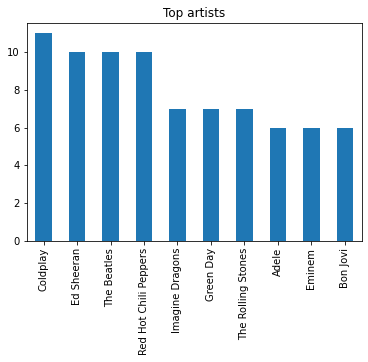

In [10]:
spotify_top["Artist"].value_counts()[:10].plot(kind="bar")
plt.title("Top artists")

Of the top artists, we expect to see Imagine Dragons, Ed Sheeran and Cold play to make song with the highest popularity

Text(0.5, 1.0, 'Top artists based on Popularity')

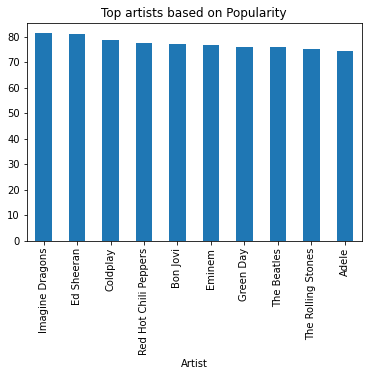

In [11]:
spotify_top2=spotify_top.groupby(['Artist'])['Popularity'].agg(["mean", "count"]).sort_values(by='count', ascending=False)
spotify_top2['mean'][:10].sort_values(ascending=False).plot(kind='bar')
plt.title("Top artists based on Popularity")

In [19]:
train_features, test_features, train_labels, test_labels = train_test_split(spotify.drop(['Title', 'Artist', 'Top Genre', 'Popularity','Percentile'], axis=1), spotify['Popularity'], test_size = 0.2, random_state = 42)

In [57]:
rmse=[]
rmse_train=[]
for i in range (2,11):
    model = RandomForestRegressor(n_estimators=1000, random_state=42, max_depth=i)
    model.fit(train_features, train_labels)
    pred = model.predict(test_features)
    predtrain= model.predict(train_features)
    rmse.append( np.sqrt(metrics.mean_squared_error(test_labels, pred)))
    rmse_train.append(np.sqrt(metrics.mean_squared_error(train_labels, predtrain)))
d = {'Test': rmse, 'Train': rmse_train}
df = pd.DataFrame(data=d, index=[2,3,4,5,6,7,8,9,10])


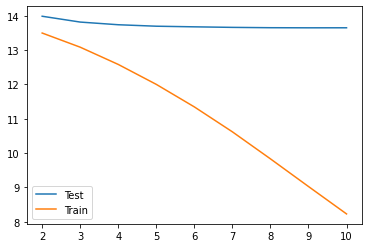

In [58]:
df["Test"].plot(label="Test")
df["Train"].plot(label="Train")
plt.legend(loc="best")

In [60]:
model = RandomForestRegressor(n_estimators=1000, random_state=42, max_depth=3)
model.fit(train_features, train_labels)
pred = model.predict(test_features)
predtrain= model.predict(train_features)
print(np.sqrt(metrics.mean_squared_error(test_labels, pred)))
print(np.sqrt(metrics.mean_squared_error(train_labels, predtrain)))

13.817814220070519
13.085703991376297


Year, Loudness and Dancebility the most important varaibles

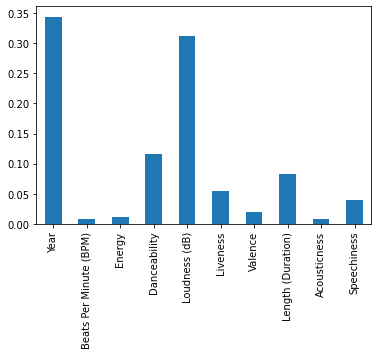

In [61]:
importance = model.feature_importances_
impor_ser=pd.Series(importance)
impor_ser.index = train_features.columns
impor_ser.plot(kind="bar")

In [62]:
param_grid = {'learning_rate': [0.001,.01, .1], 'max_depth': [2,3,4,5,6,7], 'n_estimators': [100,500]} 

In [63]:
from sklearn.model_selection import GridSearchCV

In [64]:
grid = GridSearchCV(GradientBoostingRegressor(),param_grid,refit=True,verbose=0)

In [65]:
grid.fit(train_features,train_labels)

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
              

In [66]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}

In [67]:
pred = grid.predict(test_features)
predtrain= grid.predict(train_features)
print('RMSE: '+str(i), np.sqrt(metrics.mean_squared_error(test_labels, pred)))
print('RMSE Train: '+str(i), np.sqrt(metrics.mean_squared_error(train_labels, predtrain)))

RMSE: 10 13.830671429442429
RMSE Train: 10 12.144704665749698


In [71]:
model = GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=2, learning_rate=.1)
model.fit(train_features, train_labels)
pred = model.predict(test_features)
predtrain= model.predict(train_features)
print('RMSE: '+str(i), np.sqrt(metrics.mean_squared_error(test_labels, pred)))
print('RMSE Train:'+str(i), np.sqrt(metrics.mean_squared_error(train_labels, predtrain)))
print("\n")


RMSE: 10 13.826326867954794
RMSE Train:10 12.144704665749696




Year, Loudness and Length the most important varaibles

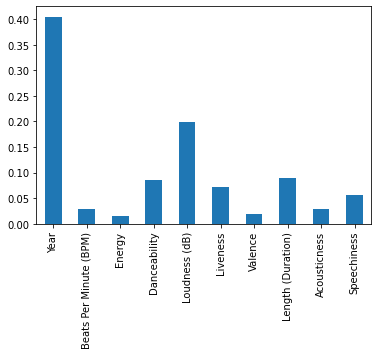

In [72]:
importance = model.feature_importances_
impor_ser=pd.Series(importance)
impor_ser.index = train_features.columns
impor_ser.plot(kind="bar")